# Import modules

In [1]:
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from sklearn.linear_model import LinearRegression

# Import and combine data

In [2]:
resale_list = ['resale1999.csv','resale2000.csv','resale2012.csv','resale2015.csv','resale2017.csv']

In [3]:
resale_df_list = [pd.read_csv(i) for i in resale_list]
resale = pd.concat(resale_df_list, ignore_index=True)
resale.to_csv("resale_raw.csv", index = False)

In [4]:
resale = resale.drop(columns=["remaining_lease"])
resale['year'] = pd.DatetimeIndex(pd.to_datetime(resale['month'])).year
resale['date'] = pd.DatetimeIndex(pd.to_datetime(resale['month']))
resale['month'] = pd.DatetimeIndex(pd.to_datetime(resale['month'])).month
resale["remaining_lease"] = (resale['lease_commence_date'] + 99) - resale['year']

In [5]:
cols = list(resale)
cols.insert(0, cols.pop(cols.index("year")))
cols.insert(0, cols.pop(cols.index("date")))
resale = resale.loc[:, cols]

print(resale.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896646 entries, 0 to 896645
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 896646 non-null  datetime64[ns]
 1   year                 896646 non-null  int32         
 2   month                896646 non-null  int32         
 3   town                 896646 non-null  object        
 4   flat_type            896646 non-null  object        
 5   block                896646 non-null  object        
 6   street_name          896646 non-null  object        
 7   storey_range         896646 non-null  object        
 8   floor_area_sqm       896646 non-null  float64       
 9   flat_model           896646 non-null  object        
 10  lease_commence_date  896646 non-null  int64         
 11  resale_price         896646 non-null  float64       
 12  remaining_lease      896646 non-null  int64         
dtypes: datetime64[

In [6]:
resale.to_csv("resale.csv", index=False)
house = resale.groupby(["town", "block", "street_name"]).size().reset_index(name='count').sort_values("count", ascending = False)
house = house.reset_index(drop = True)
house

,town,block,street_name,count
0,JURONG WEST,211,BOON LAY PL,809
1,JURONG WEST,185,BOON LAY AVE,762
2,JURONG WEST,208,BOON LAY PL,757
3,JURONG WEST,186,BOON LAY AVE,752
4,JURONG WEST,210,BOON LAY PL,734
...,...,...,...,...
9724,ANG MO KIO,702,ANG MO KIO AVE 8,1
9725,ANG MO KIO,226F,ANG MO KIO AVE 1,1
9726,BUKIT MERAH,165,BT MERAH CTRL,1
9727,CLEMENTI,516,WEST COAST RD,1


# Combine top three blocks of top three towns data

In [7]:
tamp_house = house[(house.town == "TAMPINES")]
tamp_house.head(1)

,town,block,street_name,count
21,TAMPINES,267,TAMPINES ST 21,426


In [8]:
bedok_house = house[(house.town == "BEDOK")]
bedok_house.head(1)

,town,block,street_name,count
8,BEDOK,534,BEDOK NTH ST 3,569


In [9]:
yishun_house = house[(house.town == "YISHUN")]
yishun_house.head(1)

,town,block,street_name,count
16,YISHUN,107,YISHUN RING RD,455


In [10]:
blk = resale[((resale.town == "TAMPINES") & (resale.block == "267") & (resale.street_name == "TAMPINES ST 21")) |
             ((resale.town == "BEDOK") & (resale.block == "534") & (resale.street_name == "BEDOK NTH ST 3")) |
             ((resale.town == "YISHUN") & (resale.block == "107") & (resale.street_name == "YISHUN RING RD"))]

blk = blk.reset_index(drop=True)

blk

,date,year,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,1990-01-01,1990,1,BEDOK,2 ROOM,534,BEDOK NTH ST 3,13 TO 15,45.0,IMPROVED,1986,26000.0,95
1,1990-01-01,1990,1,TAMPINES,3 ROOM,267,TAMPINES ST 21,07 TO 09,79.0,MODEL A,1983,52000.0,92
2,1990-01-01,1990,1,YISHUN,3 ROOM,107,YISHUN RING RD,04 TO 06,67.0,NEW GENERATION,1982,33000.0,91
3,1990-02-01,1990,2,BEDOK,2 ROOM,534,BEDOK NTH ST 3,07 TO 09,45.0,IMPROVED,1986,31200.0,95
4,1990-02-01,1990,2,TAMPINES,3 ROOM,267,TAMPINES ST 21,10 TO 12,79.0,MODEL A,1983,45000.0,92
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,2022-12-01,2022,12,YISHUN,3 ROOM,107,YISHUN RING RD,07 TO 09,67.0,New Generation,1982,360000.0,59
1446,2023-01-01,2023,1,TAMPINES,3 ROOM,267,TAMPINES ST 21,04 TO 06,79.0,Model A,1983,412000.0,59
1447,2023-01-01,2023,1,TAMPINES,3 ROOM,267,TAMPINES ST 21,10 TO 12,75.0,Model A,1983,432000.0,59
1448,2023-01-01,2023,1,TAMPINES,3 ROOM,267,TAMPINES ST 21,04 TO 06,75.0,Model A,1983,410000.0,59


# Split Train Test set 80:20 ratio

In [11]:
blkcopy = blk.copy()
blkcopy['date'] = pd.to_numeric(blkcopy['date'], errors='coerce')
y = pd.DataFrame(blkcopy['resale_price'])
X = pd.DataFrame(blkcopy['date'])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

print("Train Set :", x_train.shape, y_train.shape)
print("Test Set  :", x_test.shape, y_test.shape)

Train Set : (1160, 1) (1160, 1)
Test Set  : (290, 1) (290, 1)


# Neural Networks Prediction
## Define helper functions and building the model

In [12]:
def scale_datasets(x_train, x_test):

  """
  Standard Scale test and train data
  Z - Score normalization
  """
  standard_scaler = StandardScaler()
  x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
  )
  x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
  )
  return x_train_scaled, x_test_scaled
x_train_scaled, x_test_scaled = scale_datasets(x_train, x_test)

In [13]:
hidden_units1 = 160
hidden_units2 = 480
hidden_units3 = 256
learning_rate = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model
# build the model
model = build_model_using_sequential()

## Generating 20 Epochs

In [14]:
#loss function
msle = MeanSquaredLogarithmicError()
model.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=[msle]
)
# train the model
history = model.fit(
    x_train_scaled.values, 
    y_train.values, 
    epochs=20, 
    batch_size=64,
    validation_split=0.2
)

Epoch 1/20
15/15 [==============================] - 1s 21ms/step - loss: 65.7068 - mean_squared_logarithmic_error: 64.2591 - val_loss: 19.1178 - val_mean_squared_logarithmic_error: 19.1529
Epoch 2/20
15/15 [==============================] - 0s 4ms/step - loss: 11.8475 - mean_squared_logarithmic_error: 11.6610 - val_loss: 6.0752 - val_mean_squared_logarithmic_error: 6.0973
Epoch 3/20
15/15 [==============================] - 0s 4ms/step - loss: 4.5165 - mean_squared_logarithmic_error: 4.4616 - val_loss: 2.7383 - val_mean_squared_logarithmic_error: 2.7549
Epoch 4/20
15/15 [==============================] - 0s 4ms/step - loss: 2.2593 - mean_squared_logarithmic_error: 2.2294 - val_loss: 1.4329 - val_mean_squared_logarithmic_error: 1.4462
Epoch 5/20
15/15 [==============================] - 0s 4ms/step - loss: 1.2763 - mean_squared_logarithmic_error: 1.2636 - val_loss: 0.8133 - val_mean_squared_logarithmic_error: 0.8242
Epoch 6/20
15/15 [==============================] - 0s 4ms/step - loss: 0

# Plot the history

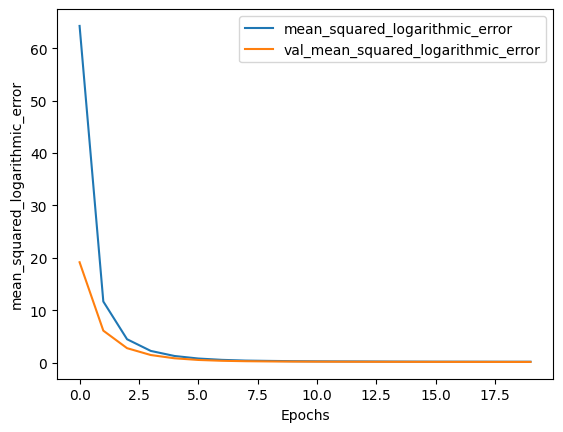

In [15]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

# Plot the regression line using neural network prediction

In [16]:
x_test['prediction'] = model.predict(x_test_scaled)

10/10 [==============================] - 0s 1ms/step


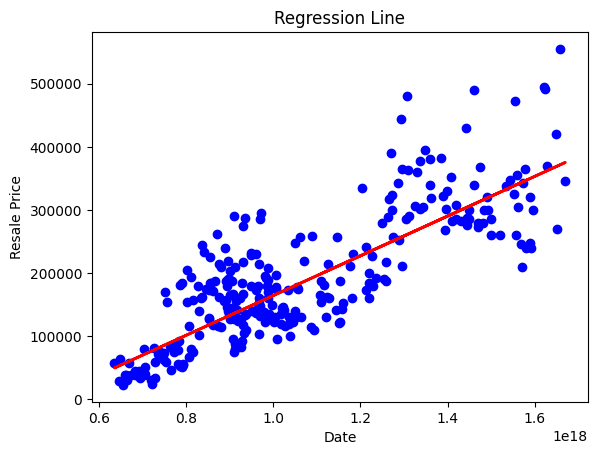

In [20]:
plt.scatter(x_test['date'], y_test['resale_price'], color='blue')
plt.title('Regression Line')
x = np.array(x_test['date'])
y = np.array(x_test['prediction'])
plt.xlabel("Date")
plt.ylabel("Resale Price")
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red', linewidth=2)

plt.show()